In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import normalize

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
img_dir = "original/"
mask_dir = "annotated/"

img_paths = [file for file in Path(img_dir).iterdir() if not file.name.startswith(".")]
mask_paths = [
    file for file in Path(mask_dir).iterdir() if not file.name.startswith(".")
]

In [23]:
df = pd.DataFrame({"image_path": img_paths, "mask_paths": mask_paths}, dtype=str)

In [24]:
class CuffDataset(Dataset):
    def __init__(self, df, transforms):
        # df contains the paths to all files
        self.df = df
        # transforms is the set of data augmentation operations
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255
        mask = cv2.imread(self.df.iloc[idx, 1], 0) / 255

        augmented = self.transforms(image=image, mask=mask)
        image = augmented["image"]  # Dimension (3, 255, 255)
        mask = augmented["mask"]  # Dimension (255, 255)
        image = normalize(
            image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), inplace=True
        )
        mask = np.expand_dims(mask, axis=0)
        return image, mask

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

PATCH_SIZE = 256

transforms = A.Compose(
    [
        A.RandomCrop(width=PATCH_SIZE, height=PATCH_SIZE, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        ToTensorV2(),
    ]
)

In [26]:
# Split df into train and test data
train_df, val_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [27]:
train_dataset = CuffDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=28, shuffle=False)

val_dataset = CuffDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1034, 2066, 3)
(1034, 2066, 3)
(1034, 2066, 3)
(1034, 2066, 3)


<Figure size 640x480 with 0 Axes>

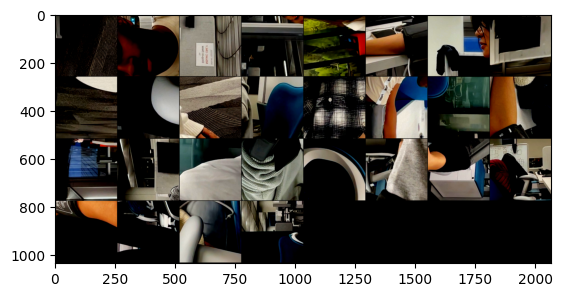

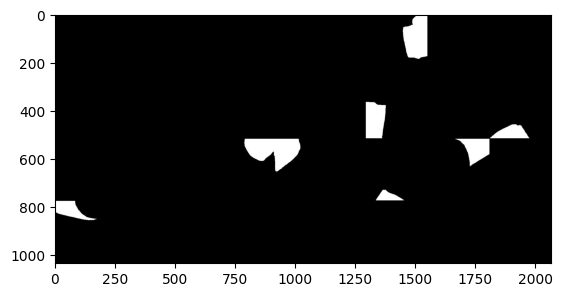

<Figure size 640x480 with 0 Axes>

In [28]:
def imshow(img):
    # img = (img * 0.5 * 255) + (0.5 * 255)   # unnormalize
    npimg = np.float32(img)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    npimg = cv2.cvtColor(npimg, cv2.COLOR_BGR2RGB)
    print(npimg.shape)
    plt.imshow(npimg, vmin=0, vmax=1)


# get some random training images
dataiter = iter(train_dataloader)
images, masks = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
plt.figure()
imshow(torchvision.utils.make_grid(masks))
plt.figure()